In [1]:
from models import LLMInference
from vllm import LLM
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"
llm = LLM("/mnt/sharedata/hdd/zhanghx/ssd2/zhanghx/models/s1.1-3B", tensor_parallel_size=8, gpu_memory_utilization=0.5, task="embed")

INFO 03-31 10:40:41 __init__.py:207] Automatically detected platform cuda.
INFO 03-31 10:40:41 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 03-31 10:40:47 config.py:1382] Defaulting to use mp for distributed inference
INFO 03-31 10:40:47 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/mnt/sharedata/hdd/zhanghx/ssd2/zhanghx/models/s1.1-3B', speculative_config=None, tokenizer='/mnt/sharedata/hdd/zhanghx/ssd2/zhanghx/models/s1.1-3B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=8, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=N

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


(VllmWorkerProcess pid=1687880) INFO 03-31 10:42:43 model_runner.py:1115] Loading model weights took 0.7536 GB
INFO 03-31 10:42:43 model_runner.py:1115] Loading model weights took 0.7536 GB
(VllmWorkerProcess pid=1687895) INFO 03-31 10:42:43 model_runner.py:1115] Loading model weights took 0.7536 GB
(VllmWorkerProcess pid=1687885) (VllmWorkerProcess pid=1687890) INFO 03-31 10:42:43 model_runner.py:1115] Loading model weights took 0.7536 GB
INFO 03-31 10:42:43 model_runner.py:1115] Loading model weights took 0.7536 GB
(VllmWorkerProcess pid=1687877) INFO 03-31 10:42:43 model_runner.py:1115] Loading model weights took 0.7536 GB
(VllmWorkerProcess pid=1687905) INFO 03-31 10:42:43 model_runner.py:1115] Loading model weights took 0.7536 GB
(VllmWorkerProcess pid=1687900) INFO 03-31 10:42:43 model_runner.py:1115] Loading model weights took 0.7536 GB


In [16]:
import json
with open(f"outputs_exp/s1.1-3B_gsm8k_fullthinking_nodup.jsonl", "r", encoding="utf-8") as f:
    lines = f.readlines()
    questions = [json.loads(l)["question"] for l in lines]
    responses = [json.loads(l)["response"] for l in lines]

with open(f"outputs_exp/s1.1-3B_gsm8k_min_tokens_fixed.jsonl", "r", encoding="utf-8") as f:
    lines = f.readlines()
    questions_conb = [json.loads(l)["question"] for l in lines]
    thinking_budgets = [json.loads(l)["thinking_budget"] for l in lines]
    token_useds = [json.loads(l)["token_used"] for l in lines]

full_dict = {q:{"response":r} for q, r in zip(questions, responses)}
for i, q in enumerate(questions_conb):
    full_dict[q]["thinking_budget"] = thinking_budgets[i]
    full_dict[q]["token_used"] = token_useds[i]

In [17]:
select_qs = list(full_dict.keys())
infos = [full_dict[select_q] for select_q in select_qs]
responses = [info["response"] for info in infos]
thinking_budgets = [info["thinking_budget"] for info in infos]
token_useds = [info["token_used"] for info in infos]

In [4]:
template = lambda p: "<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\n" + p + "<|im_end|>\n<|im_start|>assistant\n"

In [5]:
inputs = [template(select_q) + "<im_start>think" + response for select_q, response in zip(select_qs, responses) ]

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/mnt/sharedata/hdd/zhanghx/ssd2/zhanghx/models/s1.1-3B")

In [7]:
inputs_token_ids = [tokenizer(i)["input_ids"] for i in inputs]

In [8]:
lengths= [len(i) for i in inputs_token_ids]
resp_start = [length - thinking_budget for length, thinking_budget in zip(lengths, thinking_budgets)]

In [9]:
embeddings = {}
in_texts = []
from tqdm import tqdm
for q, i_ids, rs in tqdm(zip(select_qs, inputs_token_ids, resp_start)):
    for j in range(0, int((len(i_ids)- rs)/100)):
        in_texts.append(tokenizer.decode(i_ids[:(rs+j*100-1)]))

0it [00:00, ?it/s]

1319it [01:59, 11.08it/s]


In [10]:
embeds = llm.embed(in_texts)

Processed prompts: 100%|██████████| 27924/27924 [25:37<00:00, 18.16it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s] 


In [11]:
embeddings = {}
i = 0
for q, i_ids, rs in tqdm(zip(select_qs, inputs_token_ids, resp_start)):
    embeddings[q] = []
    for j in range(0, int((len(i_ids)- rs)/100)):
        embeddings[q].append(embeds[i])
        i+=1

1319it [00:00, 95830.37it/s]


In [12]:
import pickle
with open("outputs_exp/s1.1-3B_gsm8k_fullthinking_nodup_embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)

In [1]:
import pickle
with open(f"outputs_exp/s1.1-3B_gsm8k_fullthinking_nodup_embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

500


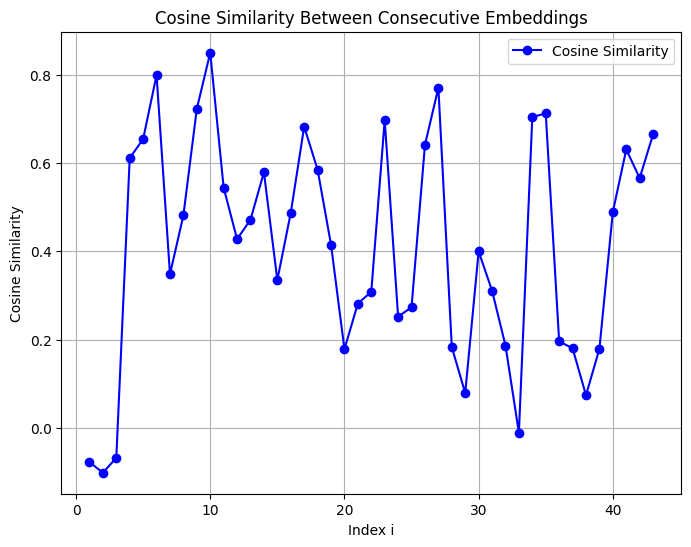

In [26]:
questions = list(embeddings.keys())
index = 4
selected_question = questions[index]
selected_embeddings = [e.outputs.embedding for e in embeddings[selected_question]]
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
similarities = []
for i in range(1, len(selected_embeddings)):
    sim = cosine_similarity(np.array(selected_embeddings[i]).reshape(1,-1), np.array(selected_embeddings[i-1]).reshape(1,-1))[0][0]
    similarities.append(sim)

import matplotlib.pyplot as plt
print(token_useds[index])

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(selected_embeddings)), similarities, marker='o', color='blue', label='Cosine Similarity')
plt.title("Cosine Similarity Between Consecutive Embeddings")
plt.xlabel("Index i")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.legend()
plt.show()